In [2]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    RobertaTokenizerFast, RobertaConfig,
    RobertaModel, PreTrainedModel,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt



In [4]:
class CustomRobertaClassifier(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.roberta = RobertaModel.from_pretrained("microsoft/codebert-base")
        self.roberta.resize_token_embeddings(config.vocab_size)
        for name, param in self.roberta.named_parameters():
            if "embeddings" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, config.num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("microsoft/codebert-base")
tokenizer.add_special_tokens({
    "additional_special_tokens": ["[CONTEXT]", "[SNIPPET]", "[COMMIT]", "[PARENT]"]
})

def load_dataset_from_json(path, batch_size=16):
    with open(path, "r") as f:
        raw_data = json.load(f)
    dataset = Dataset.from_list(raw_data)

    def preprocess(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

    tokenised = dataset.map(preprocess)
    tokenised.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return DataLoader(tokenised, batch_size=batch_size)


In [ ]:
def evaluate_model(dataloader, model, device=None, save_dir="."):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=-1).cpu()

            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)

    print(" Evaluation complete:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Buggy", "Buggy"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    plt.close()

    # Save metric chart
    metrics = [accuracy, precision, recall, f1]
    names = ["Accuracy", "Precision", "Recall", "F1 Score"]
    plt.figure(figsize=(6, 4))
    bars = plt.bar(names, metrics, color=["#4CAF50", "#2196F3", "#FFC107", "#9C27B0"])
    for i, v in enumerate(metrics):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
    plt.ylim(0, 1)
    plt.title("Model Evaluation Metrics")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "metrics_chart.png"))
    plt.close()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "../../FINAL_MODEL"

config = RobertaConfig.from_pretrained(model_path)
model = CustomRobertaClassifier(config)
model.load_state_dict(torch.load(os.path.join(model_path, "pytorch_model.bin"), map_location=device))
model.to(device)
model.eval()

print(" Model loaded.")


/home/olan_healy/anaconda3/lib/python3.11/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, 

 Model loaded.


In [18]:
sstubs_test = load_dataset_from_json("../../Data/SSTUBS_ENHANCED_26MAR_MASKED/test.json")
metrics = evaluate_model(sstubs_test, model)


Map:   0%|          | 0/4748 [00:00<?, ? examples/s]

 Evaluation complete:
Accuracy : 0.7778
Precision: 0.7333
Recall   : 0.8732
F1 Score : 0.7972


In [11]:
defects4j = load_dataset_from_json("../../Data/27_DEFECTS4J/test.json")
metrics = evaluate_model(defects4j, model)

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

 Evaluation complete:
Accuracy : 0.6154
Precision: 1.0000
Recall   : 0.6154
F1 Score : 0.7619


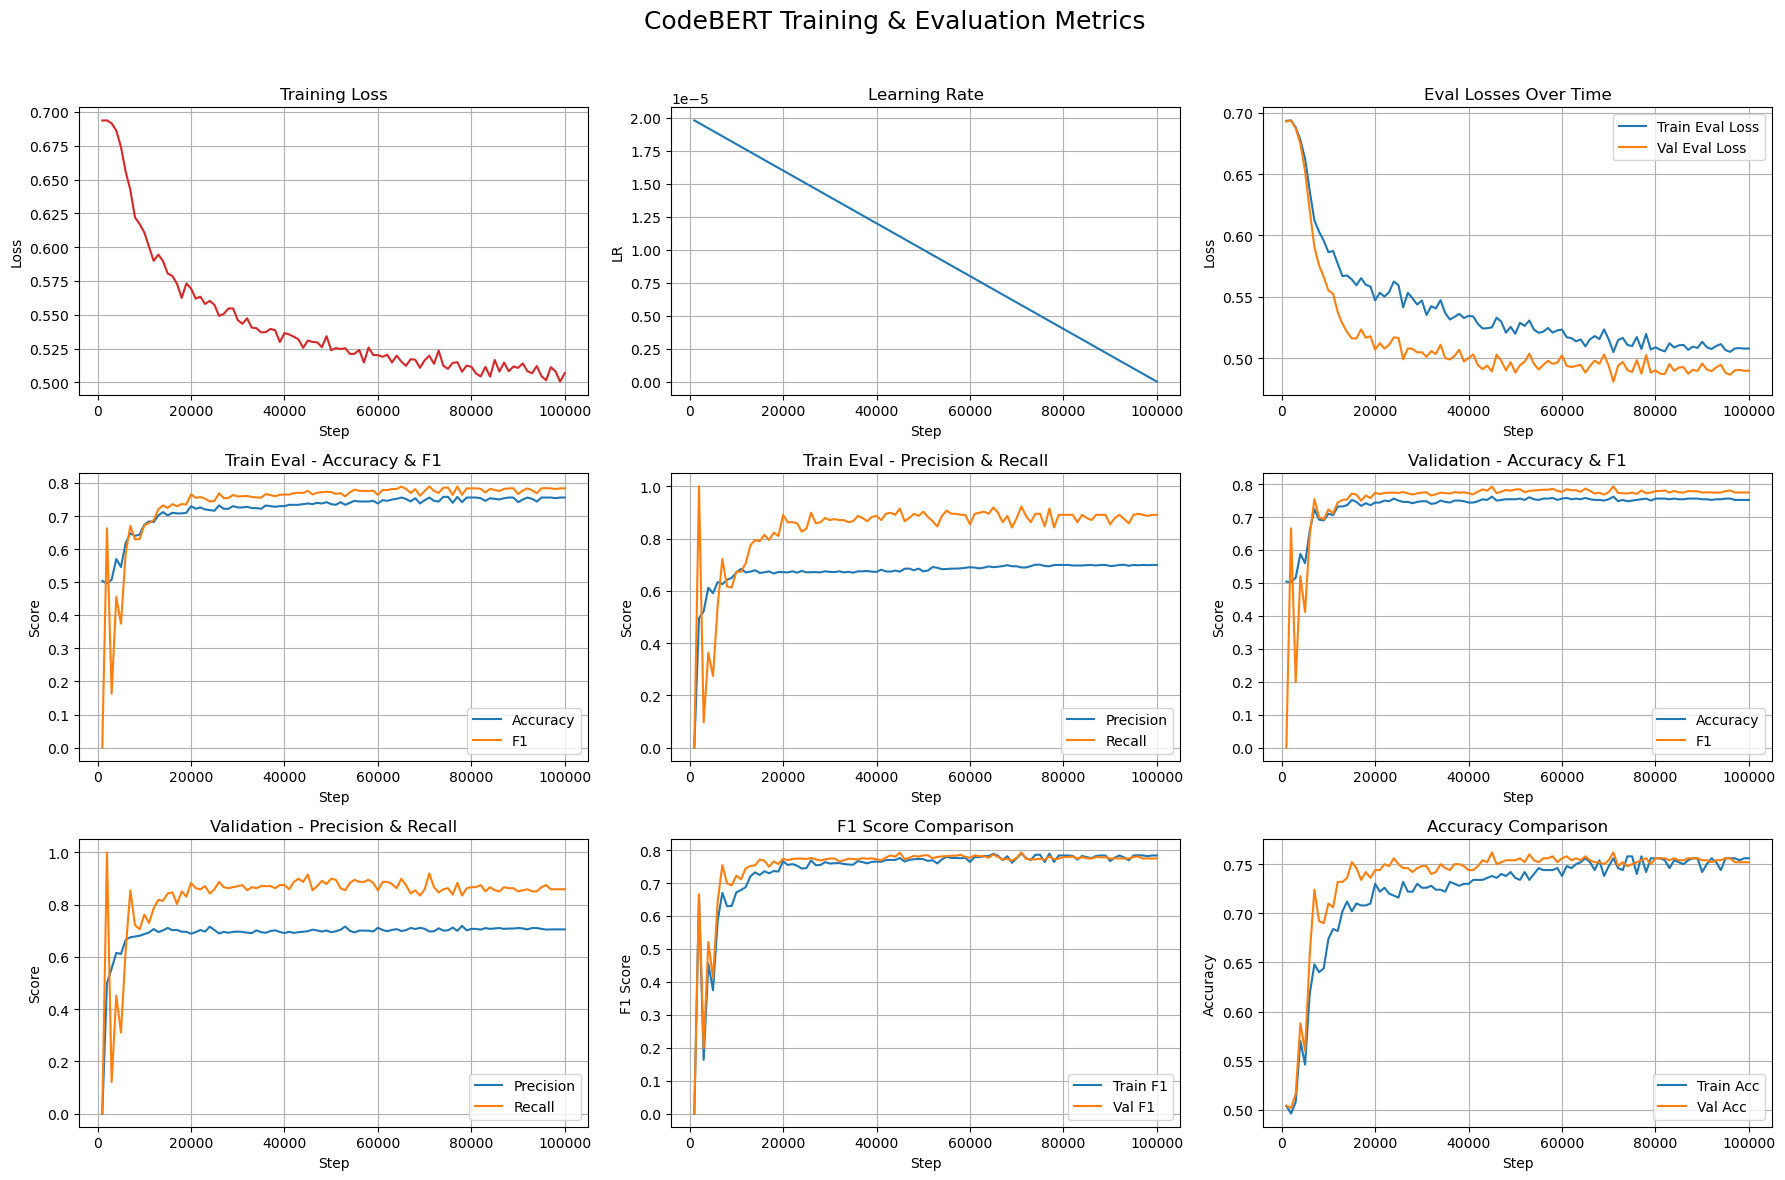

In [ ]:

# Load CSV
log_path = '../../FINAL_MODEL/final_log.csv'
df = pd.read_csv(log_path)
df = df[df['step'].notna()]
df['step'] = df['step'].astype(int)


loss_df = df[df['loss'].notna()]
lr_df = df[df['learning_rate'].notna()]
train_df = df[df['eval_train_val_accuracy'].notna()]
val_df = df[df['eval_val_accuracy'].notna()]


fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("CodeBERT Training & Evaluation Metrics", fontsize=18)

# Training Loss
axs[0, 0].plot(loss_df['step'], loss_df['loss'], label='Training Loss', color='tab:red')
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Step')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Learning Rate
axs[0, 1].plot(lr_df['step'], lr_df['learning_rate'], label='Learning Rate', color='tab:blue')
axs[0, 1].set_title('Learning Rate')
axs[0, 1].set_xlabel('Step')
axs[0, 1].set_ylabel('LR')
axs[0, 1].grid(True)

# Eval Loss (Train & Val)
axs[0, 2].plot(train_df['step'], train_df['eval_train_val_loss'], label='Train Eval Loss')
axs[0, 2].plot(val_df['step'], val_df['eval_val_loss'], label='Val Eval Loss')
axs[0, 2].set_title('Eval Losses Over Time')
axs[0, 2].set_xlabel('Step')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].legend()
axs[0, 2].grid(True)

# Train - Accuracy & F1
axs[1, 0].plot(train_df['step'], train_df['eval_train_val_accuracy'], label='Accuracy')
axs[1, 0].plot(train_df['step'], train_df['eval_train_val_f1'], label='F1')
axs[1, 0].set_title('Train Eval - Accuracy & F1')
axs[1, 0].set_xlabel('Step')
axs[1, 0].set_ylabel('Score')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Train - Precision & Recall
axs[1, 1].plot(train_df['step'], train_df['eval_train_val_precision'], label='Precision')
axs[1, 1].plot(train_df['step'], train_df['eval_train_val_recall'], label='Recall')
axs[1, 1].set_title('Train Eval - Precision & Recall')
axs[1, 1].set_xlabel('Step')
axs[1, 1].set_ylabel('Score')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Val - Accuracy & F1
axs[1, 2].plot(val_df['step'], val_df['eval_val_accuracy'], label='Accuracy')
axs[1, 2].plot(val_df['step'], val_df['eval_val_f1'], label='F1')
axs[1, 2].set_title('Validation - Accuracy & F1')
axs[1, 2].set_xlabel('Step')
axs[1, 2].set_ylabel('Score')
axs[1, 2].legend()
axs[1, 2].grid(True)

# Val - Precision & Recall
axs[2, 0].plot(val_df['step'], val_df['eval_val_precision'], label='Precision')
axs[2, 0].plot(val_df['step'], val_df['eval_val_recall'], label='Recall')
axs[2, 0].set_title('Validation - Precision & Recall')
axs[2, 0].set_xlabel('Step')
axs[2, 0].set_ylabel('Score')
axs[2, 0].legend()
axs[2, 0].grid(True)

# F1 Comparison
axs[2, 1].plot(train_df['step'], train_df['eval_train_val_f1'], label='Train F1')
axs[2, 1].plot(val_df['step'], val_df['eval_val_f1'], label='Val F1')
axs[2, 1].set_title('F1 Score Comparison')
axs[2, 1].set_xlabel('Step')
axs[2, 1].set_ylabel('F1 Score')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Accuracy Comparison
axs[2, 2].plot(train_df['step'], train_df['eval_train_val_accuracy'], label='Train Acc')
axs[2, 2].plot(val_df['step'], val_df['eval_val_accuracy'], label='Val Acc')
axs[2, 2].set_title('Accuracy Comparison')
axs[2, 2].set_xlabel('Step')
axs[2, 2].set_ylabel('Accuracy')
axs[2, 2].legend()
axs[2, 2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("training_dashboard.png")
plt.show()